<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:32] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


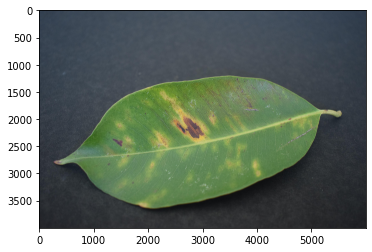

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

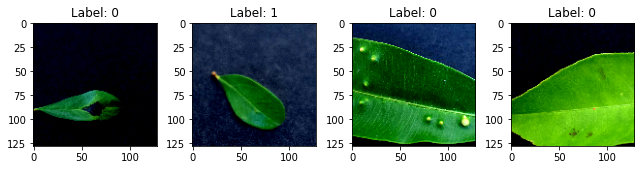

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:37] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2573204229014778 samples/sec                   batch loss = 0.7424702644348145 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2709756000371508 samples/sec                   batch loss = 0.8103318810462952 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.27287407274552 samples/sec                   batch loss = 0.5317883491516113 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.268017336779164 samples/sec                   batch loss = 0.41083836555480957 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2417591022797536 samples/sec                   batch loss = 0.2971600592136383 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.268135514072026 samples/sec                   batch loss = 0.611270546913147 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2658332560604277 samples/sec                   batch loss = 0.3687262237071991 | accuracy = 0.65


Epoch[1] Batch[40] Speed: 1.272650644486809 samples/sec                   batch loss = 0.8684415221214294 | accuracy = 0.66875


Epoch[1] Batch[45] Speed: 1.2725677237077673 samples/sec                   batch loss = 0.5880788564682007 | accuracy = 0.6611111111111111


Epoch[1] Batch[50] Speed: 1.2747697017653248 samples/sec                   batch loss = 1.5348482131958008 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2735326476977495 samples/sec                   batch loss = 0.49804723262786865 | accuracy = 0.6409090909090909


Epoch[1] Batch[60] Speed: 1.269005124742044 samples/sec                   batch loss = 0.6524618864059448 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2787755864250463 samples/sec                   batch loss = 0.7225514650344849 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2690220184625691 samples/sec                   batch loss = 0.5163155794143677 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.272804737864926 samples/sec                   batch loss = 0.6234352588653564 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2729621524551533 samples/sec                   batch loss = 0.25511541962623596 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2696070489261981 samples/sec                   batch loss = 0.671571671962738 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.2723279996147498 samples/sec                   batch loss = 0.39744389057159424 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.280515832793972 samples/sec                   batch loss = 0.8867284655570984 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.2703380379227784 samples/sec                   batch loss = 0.38843750953674316 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2712209792632332 samples/sec                   batch loss = 0.6822013854980469 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2712967886245674 samples/sec                   batch loss = 0.5963842868804932 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2679471884160227 samples/sec                   batch loss = 1.4274168014526367 | accuracy = 0.6347826086956522


Epoch[1] Batch[120] Speed: 1.2684233338804538 samples/sec                   batch loss = 0.6295673847198486 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.266757956831873 samples/sec                   batch loss = 0.4784580171108246 | accuracy = 0.634


Epoch[1] Batch[130] Speed: 1.2724960093273203 samples/sec                   batch loss = 0.5568803548812866 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2638903924247407 samples/sec                   batch loss = 0.47982147336006165 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2682226515845587 samples/sec                   batch loss = 0.3700476586818695 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.278819156779899 samples/sec                   batch loss = 0.673234224319458 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2780562764118961 samples/sec                   batch loss = 0.4731232225894928 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2725442684515784 samples/sec                   batch loss = 0.34091717004776 | accuracy = 0.6435483870967742


Epoch[1] Batch[160] Speed: 1.2734247709921869 samples/sec                   batch loss = 0.5442980527877808 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.275130509755303 samples/sec                   batch loss = 0.9499993920326233 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.2773138520037361 samples/sec                   batch loss = 0.6063319444656372 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.27614620825081 samples/sec                   batch loss = 0.605594277381897 | accuracy = 0.64


Epoch[1] Batch[180] Speed: 1.2727840740552485 samples/sec                   batch loss = 0.268191933631897 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.2757118748639864 samples/sec                   batch loss = 0.7331221103668213 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.2765931737803906 samples/sec                   batch loss = 0.8132822513580322 | accuracy = 0.6407894736842106


Epoch[1] Batch[195] Speed: 1.2713546872501673 samples/sec                   batch loss = 0.7886466383934021 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2760883576938307 samples/sec                   batch loss = 0.4963064193725586 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.2721815460147001 samples/sec                   batch loss = 0.42669928073883057 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.269678918477855 samples/sec                   batch loss = 0.6883531212806702 | accuracy = 0.6464285714285715


Epoch[1] Batch[215] Speed: 1.2757437896592705 samples/sec                   batch loss = 0.4264106750488281 | accuracy = 0.6465116279069767


Epoch[1] Batch[220] Speed: 1.264170096617309 samples/sec                   batch loss = 0.437338650226593 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.265401522791604 samples/sec                   batch loss = 0.7368800640106201 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.2706987473133289 samples/sec                   batch loss = 0.40475547313690186 | accuracy = 0.6489130434782608


Epoch[1] Batch[235] Speed: 1.2796780107056194 samples/sec                   batch loss = 0.6003257036209106 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.2715313058163566 samples/sec                   batch loss = 0.6068107485771179 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2708413941883066 samples/sec                   batch loss = 0.239246666431427 | accuracy = 0.6561224489795918


Epoch[1] Batch[250] Speed: 1.2749986225754002 samples/sec                   batch loss = 0.5730191469192505 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2735702541786376 samples/sec                   batch loss = 1.0449275970458984 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.268159382232845 samples/sec                   batch loss = 0.6137596368789673 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.272726624465516 samples/sec                   batch loss = 0.6279803514480591 | accuracy = 0.6622641509433962


Epoch[1] Batch[270] Speed: 1.276228333988542 samples/sec                   batch loss = 0.8154852390289307 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.2762764882727395 samples/sec                   batch loss = 0.3815743029117584 | accuracy = 0.6681818181818182


Epoch[1] Batch[280] Speed: 1.2736064126323854 samples/sec                   batch loss = 0.8477551937103271 | accuracy = 0.6696428571428571


Epoch[1] Batch[285] Speed: 1.272086243865127 samples/sec                   batch loss = 0.5474786758422852 | accuracy = 0.6701754385964912


Epoch[1] Batch[290] Speed: 1.270847651363339 samples/sec                   batch loss = 0.5082323551177979 | accuracy = 0.6724137931034483


Epoch[1] Batch[295] Speed: 1.2676359268345407 samples/sec                   batch loss = 0.8836880326271057 | accuracy = 0.6754237288135593


Epoch[1] Batch[300] Speed: 1.2759057163673089 samples/sec                   batch loss = 0.3697044253349304 | accuracy = 0.675


Epoch[1] Batch[305] Speed: 1.272425847090466 samples/sec                   batch loss = 0.33822762966156006 | accuracy = 0.6770491803278689


Epoch[1] Batch[310] Speed: 1.267678645598351 samples/sec                   batch loss = 0.9157180786132812 | accuracy = 0.6758064516129032


Epoch[1] Batch[315] Speed: 1.267748860045713 samples/sec                   batch loss = 0.7694432735443115 | accuracy = 0.676984126984127


Epoch[1] Batch[320] Speed: 1.2682788323911387 samples/sec                   batch loss = 0.2242511659860611 | accuracy = 0.67734375


Epoch[1] Batch[325] Speed: 1.2763942679930893 samples/sec                   batch loss = 0.7965462803840637 | accuracy = 0.6776923076923077


Epoch[1] Batch[330] Speed: 1.2702545526459106 samples/sec                   batch loss = 0.6398118734359741 | accuracy = 0.6803030303030303


Epoch[1] Batch[335] Speed: 1.2753880639596942 samples/sec                   batch loss = 0.7395790219306946 | accuracy = 0.6813432835820895


Epoch[1] Batch[340] Speed: 1.2728027100782116 samples/sec                   batch loss = 0.3704553544521332 | accuracy = 0.6830882352941177


Epoch[1] Batch[345] Speed: 1.2679676954679637 samples/sec                   batch loss = 1.3270004987716675 | accuracy = 0.6818840579710145


Epoch[1] Batch[350] Speed: 1.2677216546165269 samples/sec                   batch loss = 0.3508007824420929 | accuracy = 0.6835714285714286


Epoch[1] Batch[355] Speed: 1.2763255200577257 samples/sec                   batch loss = 1.0203464031219482 | accuracy = 0.6838028169014084


Epoch[1] Batch[360] Speed: 1.2718379273152125 samples/sec                   batch loss = 1.6342487335205078 | accuracy = 0.6826388888888889


Epoch[1] Batch[365] Speed: 1.273044448460992 samples/sec                   batch loss = 0.5639944076538086 | accuracy = 0.6815068493150684


Epoch[1] Batch[370] Speed: 1.2701829064063577 samples/sec                   batch loss = 0.7059470415115356 | accuracy = 0.6817567567567567


Epoch[1] Batch[375] Speed: 1.2766318355175756 samples/sec                   batch loss = 0.5480487942695618 | accuracy = 0.6826666666666666


Epoch[1] Batch[380] Speed: 1.2757402003776757 samples/sec                   batch loss = 0.4667772352695465 | accuracy = 0.6822368421052631


Epoch[1] Batch[385] Speed: 1.2774262792067497 samples/sec                   batch loss = 0.8741979598999023 | accuracy = 0.6798701298701298


Epoch[1] Batch[390] Speed: 1.2714213590885108 samples/sec                   batch loss = 0.3582450747489929 | accuracy = 0.6807692307692308


Epoch[1] Batch[395] Speed: 1.2710472394379129 samples/sec                   batch loss = 0.5085530877113342 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.2747168185082518 samples/sec                   batch loss = 0.4409952759742737 | accuracy = 0.6825


Epoch[1] Batch[405] Speed: 1.2704785834312098 samples/sec                   batch loss = 0.8379589915275574 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.2675068302228303 samples/sec                   batch loss = 0.5442006587982178 | accuracy = 0.6810975609756098


Epoch[1] Batch[415] Speed: 1.2707777670305092 samples/sec                   batch loss = 0.8393054604530334 | accuracy = 0.6825301204819277


Epoch[1] Batch[420] Speed: 1.2720865332225115 samples/sec                   batch loss = 0.4457584619522095 | accuracy = 0.6839285714285714


Epoch[1] Batch[425] Speed: 1.2767525956699795 samples/sec                   batch loss = 0.8140892386436462 | accuracy = 0.6841176470588235


Epoch[1] Batch[430] Speed: 1.273456281473556 samples/sec                   batch loss = 0.5833655595779419 | accuracy = 0.6831395348837209


Epoch[1] Batch[435] Speed: 1.2801105564231774 samples/sec                   batch loss = 0.5043905973434448 | accuracy = 0.6833333333333333


Epoch[1] Batch[440] Speed: 1.274788880294329 samples/sec                   batch loss = 0.2720676064491272 | accuracy = 0.6840909090909091


Epoch[1] Batch[445] Speed: 1.2709339103936845 samples/sec                   batch loss = 0.3012699782848358 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.2740357335957766 samples/sec                   batch loss = 0.9105772376060486 | accuracy = 0.6844444444444444


Epoch[1] Batch[455] Speed: 1.2694415300958262 samples/sec                   batch loss = 0.4950575828552246 | accuracy = 0.6851648351648352


Epoch[1] Batch[460] Speed: 1.2712121177680236 samples/sec                   batch loss = 1.0725396871566772 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.2656739711995548 samples/sec                   batch loss = 0.9865666031837463 | accuracy = 0.6838709677419355


Epoch[1] Batch[470] Speed: 1.2663849511594742 samples/sec                   batch loss = 0.525732159614563 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2680550974448153 samples/sec                   batch loss = 0.2711775004863739 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2726478448896112 samples/sec                   batch loss = 0.23983584344387054 | accuracy = 0.6833333333333333


Epoch[1] Batch[485] Speed: 1.275057440305554 samples/sec                   batch loss = 0.3432859182357788 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.2756201165979482 samples/sec                   batch loss = 0.41494613885879517 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.276002465116495 samples/sec                   batch loss = 0.4043102264404297 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.271439473454865 samples/sec                   batch loss = 1.1468244791030884 | accuracy = 0.684


Epoch[1] Batch[505] Speed: 1.2708171361845162 samples/sec                   batch loss = 0.3812629282474518 | accuracy = 0.6851485148514852


Epoch[1] Batch[510] Speed: 1.268592999743366 samples/sec                   batch loss = 0.5793207883834839 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.2761454316985363 samples/sec                   batch loss = 0.8060904145240784 | accuracy = 0.6839805825242719


Epoch[1] Batch[520] Speed: 1.2715056723641038 samples/sec                   batch loss = 0.9770200252532959 | accuracy = 0.6836538461538462


Epoch[1] Batch[525] Speed: 1.2720178627615253 samples/sec                   batch loss = 0.8250729441642761 | accuracy = 0.6833333333333333


Epoch[1] Batch[530] Speed: 1.2697258110205816 samples/sec                   batch loss = 0.4912203550338745 | accuracy = 0.6830188679245283


Epoch[1] Batch[535] Speed: 1.270483778727694 samples/sec                   batch loss = 0.4519830644130707 | accuracy = 0.6836448598130841


Epoch[1] Batch[540] Speed: 1.2735189204354305 samples/sec                   batch loss = 0.4255644679069519 | accuracy = 0.6824074074074075


Epoch[1] Batch[545] Speed: 1.2721793272800508 samples/sec                   batch loss = 0.5224844217300415 | accuracy = 0.6821100917431193


Epoch[1] Batch[550] Speed: 1.2698966906132627 samples/sec                   batch loss = 0.426356703042984 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.267723857829664 samples/sec                   batch loss = 0.5559014081954956 | accuracy = 0.6815315315315316


Epoch[1] Batch[560] Speed: 1.2706530339375945 samples/sec                   batch loss = 0.3749922513961792 | accuracy = 0.6816964285714285


Epoch[1] Batch[565] Speed: 1.2666420443340902 samples/sec                   batch loss = 0.7249710559844971 | accuracy = 0.6827433628318584


Epoch[1] Batch[570] Speed: 1.270973963209728 samples/sec                   batch loss = 0.4962424337863922 | accuracy = 0.6833333333333333


Epoch[1] Batch[575] Speed: 1.266754896163225 samples/sec                   batch loss = 0.22770337760448456 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.272287089550128 samples/sec                   batch loss = 0.8654868006706238 | accuracy = 0.6836206896551724


Epoch[1] Batch[585] Speed: 1.2656639456160024 samples/sec                   batch loss = 0.3790733516216278 | accuracy = 0.685042735042735


Epoch[1] Batch[590] Speed: 1.2685782277062931 samples/sec                   batch loss = 0.764602541923523 | accuracy = 0.684322033898305


Epoch[1] Batch[595] Speed: 1.267122090630124 samples/sec                   batch loss = 0.3906300365924835 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.2690920938100918 samples/sec                   batch loss = 0.7102327346801758 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.264487187217365 samples/sec                   batch loss = 0.5822259187698364 | accuracy = 0.6838842975206612


Epoch[1] Batch[610] Speed: 1.2665264398805522 samples/sec                   batch loss = 0.5112669467926025 | accuracy = 0.6844262295081968


Epoch[1] Batch[615] Speed: 1.2721033161760447 samples/sec                   batch loss = 0.4358925223350525 | accuracy = 0.6845528455284553


Epoch[1] Batch[620] Speed: 1.2634921443008893 samples/sec                   batch loss = 0.859554648399353 | accuracy = 0.6846774193548387


Epoch[1] Batch[625] Speed: 1.269176578490151 samples/sec                   batch loss = 0.42089545726776123 | accuracy = 0.6856


Epoch[1] Batch[630] Speed: 1.272800102933358 samples/sec                   batch loss = 0.49955567717552185 | accuracy = 0.6857142857142857


Epoch[1] Batch[635] Speed: 1.2668908232358544 samples/sec                   batch loss = 0.5687609314918518 | accuracy = 0.6862204724409449


Epoch[1] Batch[640] Speed: 1.2670238132009388 samples/sec                   batch loss = 0.7971494197845459 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.2717368926448664 samples/sec                   batch loss = 0.7915620803833008 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.270756976481111 samples/sec                   batch loss = 0.5052398443222046 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.2662120528069365 samples/sec                   batch loss = 0.4622572660446167 | accuracy = 0.6874045801526718


Epoch[1] Batch[660] Speed: 1.27338495016049 samples/sec                   batch loss = 0.7158849239349365 | accuracy = 0.6878787878787879


Epoch[1] Batch[665] Speed: 1.2618770760871167 samples/sec                   batch loss = 0.3882981836795807 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.2642133442002388 samples/sec                   batch loss = 0.6431970000267029 | accuracy = 0.6873134328358209


Epoch[1] Batch[675] Speed: 1.269269428605365 samples/sec                   batch loss = 0.3854900598526001 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2704339441161652 samples/sec                   batch loss = 0.8944168090820312 | accuracy = 0.6875


Epoch[1] Batch[685] Speed: 1.2687935114113564 samples/sec                   batch loss = 0.2698931396007538 | accuracy = 0.6883211678832116


Epoch[1] Batch[690] Speed: 1.2659447220058306 samples/sec                   batch loss = 0.6533364653587341 | accuracy = 0.688768115942029


Epoch[1] Batch[695] Speed: 1.2687645340373448 samples/sec                   batch loss = 0.32156887650489807 | accuracy = 0.6884892086330935


Epoch[1] Batch[700] Speed: 1.257010306497679 samples/sec                   batch loss = 0.3753598630428314 | accuracy = 0.6892857142857143


Epoch[1] Batch[705] Speed: 1.2723666929221162 samples/sec                   batch loss = 0.5402752161026001 | accuracy = 0.6879432624113475


Epoch[1] Batch[710] Speed: 1.2752409050848217 samples/sec                   batch loss = 0.5427342653274536 | accuracy = 0.6883802816901409


Epoch[1] Batch[715] Speed: 1.2655067079591027 samples/sec                   batch loss = 0.7911312580108643 | accuracy = 0.6881118881118881


Epoch[1] Batch[720] Speed: 1.2689539663887717 samples/sec                   batch loss = 0.4049793481826782 | accuracy = 0.6878472222222223


Epoch[1] Batch[725] Speed: 1.2690409284446222 samples/sec                   batch loss = 1.3352783918380737 | accuracy = 0.6879310344827586


Epoch[1] Batch[730] Speed: 1.2766175556585 samples/sec                   batch loss = 0.6954283714294434 | accuracy = 0.6863013698630137


Epoch[1] Batch[735] Speed: 1.2695396065605378 samples/sec                   batch loss = 0.497598797082901 | accuracy = 0.6870748299319728


Epoch[1] Batch[740] Speed: 1.2708283987139628 samples/sec                   batch loss = 0.30651700496673584 | accuracy = 0.6878378378378378


Epoch[1] Batch[745] Speed: 1.2716530306367642 samples/sec                   batch loss = 0.426338255405426 | accuracy = 0.6885906040268457


Epoch[1] Batch[750] Speed: 1.2704066233243259 samples/sec                   batch loss = 1.2216953039169312 | accuracy = 0.6876666666666666


Epoch[1] Batch[755] Speed: 1.2721837647570886 samples/sec                   batch loss = 0.4944358170032501 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2760624431219432 samples/sec                   batch loss = 1.178469181060791 | accuracy = 0.687828947368421


Epoch[1] Batch[765] Speed: 1.2722468574534642 samples/sec                   batch loss = 0.4918096661567688 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.2721805813465104 samples/sec                   batch loss = 0.5588226914405823 | accuracy = 0.6883116883116883


Epoch[1] Batch[775] Speed: 1.2715257164792597 samples/sec                   batch loss = 0.6314752697944641 | accuracy = 0.687741935483871


Epoch[1] Batch[780] Speed: 1.2761185441589367 samples/sec                   batch loss = 0.501759946346283 | accuracy = 0.6881410256410256


Epoch[1] Batch[785] Speed: 1.2712125030478552 samples/sec                   batch loss = 1.042340874671936 | accuracy = 0.6878980891719745


[Epoch 1] training: accuracy=0.6875
[Epoch 1] time cost: 647.2752940654755
[Epoch 1] validation: validation accuracy=0.7455555555555555


Epoch[2] Batch[5] Speed: 1.269939754143374 samples/sec                   batch loss = 0.5514497756958008 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2706025124540465 samples/sec                   batch loss = 0.7008423805236816 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2683799895655032 samples/sec                   batch loss = 0.8658862113952637 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2701097297995005 samples/sec                   batch loss = 0.5131802558898926 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2738243736402155 samples/sec                   batch loss = 0.2726571559906006 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2722387534541175 samples/sec                   batch loss = 0.6002245545387268 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.269889866080836 samples/sec                   batch loss = 0.09602236747741699 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2691251183005001 samples/sec                   batch loss = 0.6223363876342773 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2672156932412206 samples/sec                   batch loss = 0.6254189014434814 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2649463356611805 samples/sec                   batch loss = 0.3213905096054077 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2634861496529128 samples/sec                   batch loss = 0.6362768411636353 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2621389884737357 samples/sec                   batch loss = 0.5704719424247742 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2787842612701654 samples/sec                   batch loss = 0.43098998069763184 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2699352361805394 samples/sec                   batch loss = 0.3551531434059143 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.269749354689248 samples/sec                   batch loss = 0.3521716892719269 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.274584920054766 samples/sec                   batch loss = 0.5698511004447937 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2712490093712965 samples/sec                   batch loss = 0.2628908157348633 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2702297400132057 samples/sec                   batch loss = 0.1529361456632614 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2717347718600713 samples/sec                   batch loss = 0.32211941480636597 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2745222730098371 samples/sec                   batch loss = 0.28790003061294556 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2739257402808888 samples/sec                   batch loss = 0.8608965873718262 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2776016701435942 samples/sec                   batch loss = 0.557382345199585 | accuracy = 0.7454545454545455


Epoch[2] Batch[115] Speed: 1.2761239798156403 samples/sec                   batch loss = 1.261957049369812 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2725594225717445 samples/sec                   batch loss = 0.4941254258155823 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2707176110543814 samples/sec                   batch loss = 0.5453552007675171 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2658203628090061 samples/sec                   batch loss = 0.901167631149292 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2707752644283625 samples/sec                   batch loss = 0.4284061789512634 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.273860933412106 samples/sec                   batch loss = 0.9711810946464539 | accuracy = 0.75


Epoch[2] Batch[145] Speed: 1.269848439859482 samples/sec                   batch loss = 0.7975432276725769 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.2669748237211909 samples/sec                   batch loss = 0.4554270803928375 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2729664988090326 samples/sec                   batch loss = 0.41825947165489197 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.2706837337156216 samples/sec                   batch loss = 0.5412880182266235 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.266240244728325 samples/sec                   batch loss = 0.42177605628967285 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.271428200091743 samples/sec                   batch loss = 0.18650224804878235 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.268407127362857 samples/sec                   batch loss = 0.055035725235939026 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2712691417236572 samples/sec                   batch loss = 0.7153468132019043 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2694922474725119 samples/sec                   batch loss = 0.33942824602127075 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.267550689475385 samples/sec                   batch loss = 0.2011501044034958 | accuracy = 0.7631578947368421


Epoch[2] Batch[195] Speed: 1.2700876150072353 samples/sec                   batch loss = 0.2795119285583496 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2690467839340458 samples/sec                   batch loss = 0.8296329975128174 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2749231461570343 samples/sec                   batch loss = 0.747062623500824 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.2637929964306613 samples/sec                   batch loss = 0.4859105050563812 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.2651015261631797 samples/sec                   batch loss = 0.5436448454856873 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2689320837749112 samples/sec                   batch loss = 0.32650190591812134 | accuracy = 0.7579545454545454


Epoch[2] Batch[225] Speed: 1.2691650571896098 samples/sec                   batch loss = 0.4767380356788635 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2642440193896984 samples/sec                   batch loss = 0.5572341680526733 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2782511232457607 samples/sec                   batch loss = 0.3290431499481201 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2670264924223698 samples/sec                   batch loss = 0.788893461227417 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2725343267726261 samples/sec                   batch loss = 0.4756253957748413 | accuracy = 0.7571428571428571


Epoch[2] Batch[250] Speed: 1.2682459477996175 samples/sec                   batch loss = 0.7488768100738525 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.271262976725056 samples/sec                   batch loss = 0.8590185642242432 | accuracy = 0.7598039215686274


Epoch[2] Batch[260] Speed: 1.2722073996671845 samples/sec                   batch loss = 0.28885528445243835 | accuracy = 0.7576923076923077


Epoch[2] Batch[265] Speed: 1.2694118507834926 samples/sec                   batch loss = 0.29489243030548096 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.2721351471319056 samples/sec                   batch loss = 0.8127110004425049 | accuracy = 0.762962962962963


Epoch[2] Batch[275] Speed: 1.2674873913938889 samples/sec                   batch loss = 0.5799611806869507 | accuracy = 0.7609090909090909


Epoch[2] Batch[280] Speed: 1.2703274573841556 samples/sec                   batch loss = 0.5023758411407471 | accuracy = 0.7598214285714285


Epoch[2] Batch[285] Speed: 1.2641342814758376 samples/sec                   batch loss = 0.40336155891418457 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2706008765874448 samples/sec                   batch loss = 0.2777707278728485 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.2684804915323193 samples/sec                   batch loss = 0.39391085505485535 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2721188456252057 samples/sec                   batch loss = 0.5549588203430176 | accuracy = 0.7625


Epoch[2] Batch[305] Speed: 1.2726731382492713 samples/sec                   batch loss = 0.34086501598358154 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2633868180532541 samples/sec                   batch loss = 0.1685335785150528 | accuracy = 0.7645161290322581


Epoch[2] Batch[315] Speed: 1.2668816393480502 samples/sec                   batch loss = 0.6209715008735657 | accuracy = 0.7626984126984127


Epoch[2] Batch[320] Speed: 1.2724637742714582 samples/sec                   batch loss = 0.6831703782081604 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.2753594632323852 samples/sec                   batch loss = 0.573276937007904 | accuracy = 0.7576923076923077


Epoch[2] Batch[330] Speed: 1.2754931705317052 samples/sec                   batch loss = 0.4783504009246826 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.2664489039700326 samples/sec                   batch loss = 0.37701278924942017 | accuracy = 0.7574626865671642


Epoch[2] Batch[340] Speed: 1.274637211329956 samples/sec                   batch loss = 0.1311587542295456 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.2732339049392143 samples/sec                   batch loss = 0.27234122157096863 | accuracy = 0.7579710144927536


Epoch[2] Batch[350] Speed: 1.272087594200714 samples/sec                   batch loss = 0.5257983207702637 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.2741162332636276 samples/sec                   batch loss = 0.6871108412742615 | accuracy = 0.7584507042253521


Epoch[2] Batch[360] Speed: 1.2725549824736764 samples/sec                   batch loss = 0.88042813539505 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2733825339280314 samples/sec                   batch loss = 0.3731292188167572 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2653303275117223 samples/sec                   batch loss = 0.7945832014083862 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.268079729344765 samples/sec                   batch loss = 0.7374567985534668 | accuracy = 0.7606666666666667


Epoch[2] Batch[380] Speed: 1.2603617537981835 samples/sec                   batch loss = 0.7485457062721252 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.2617768585718045 samples/sec                   batch loss = 0.40061426162719727 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.271305073295928 samples/sec                   batch loss = 0.051167041063308716 | accuracy = 0.7608974358974359


Epoch[2] Batch[395] Speed: 1.2687678922744698 samples/sec                   batch loss = 0.5770096182823181 | accuracy = 0.759493670886076


Epoch[2] Batch[400] Speed: 1.2697154328643108 samples/sec                   batch loss = 0.30812281370162964 | accuracy = 0.76


Epoch[2] Batch[405] Speed: 1.2707371490909123 samples/sec                   batch loss = 0.10704728960990906 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2705876935809377 samples/sec                   batch loss = 0.10020163655281067 | accuracy = 0.7609756097560976


Epoch[2] Batch[415] Speed: 1.2655537701430313 samples/sec                   batch loss = 0.3225148618221283 | accuracy = 0.7620481927710844


Epoch[2] Batch[420] Speed: 1.2713830122924794 samples/sec                   batch loss = 0.308407723903656 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2711879419257117 samples/sec                   batch loss = 0.44081413745880127 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.267165827552409 samples/sec                   batch loss = 1.2836940288543701 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.2626787244648021 samples/sec                   batch loss = 0.2990688681602478 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2773422487024984 samples/sec                   batch loss = 0.5041586756706238 | accuracy = 0.7625


Epoch[2] Batch[445] Speed: 1.2787347480051514 samples/sec                   batch loss = 0.8903186917304993 | accuracy = 0.7612359550561798


Epoch[2] Batch[450] Speed: 1.2737455548165897 samples/sec                   batch loss = 0.3671424388885498 | accuracy = 0.7616666666666667


Epoch[2] Batch[455] Speed: 1.2736899523122105 samples/sec                   batch loss = 0.4754563271999359 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.270700287189564 samples/sec                   batch loss = 0.6382700204849243 | accuracy = 0.7597826086956522


Epoch[2] Batch[465] Speed: 1.2686653301376012 samples/sec                   batch loss = 0.6227524876594543 | accuracy = 0.7580645161290323


Epoch[2] Batch[470] Speed: 1.2690311374190915 samples/sec                   batch loss = 0.650658905506134 | accuracy = 0.7574468085106383


Epoch[2] Batch[475] Speed: 1.2761100995698385 samples/sec                   batch loss = 0.9096832275390625 | accuracy = 0.7552631578947369


Epoch[2] Batch[480] Speed: 1.2709056053586272 samples/sec                   batch loss = 0.5141814351081848 | accuracy = 0.75625


Epoch[2] Batch[485] Speed: 1.2684135523824163 samples/sec                   batch loss = 0.18150044977664948 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.2747508143840978 samples/sec                   batch loss = 0.5604537725448608 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.268865768708193 samples/sec                   batch loss = 0.4450310170650482 | accuracy = 0.7555555555555555


Epoch[2] Batch[500] Speed: 1.2703818047503506 samples/sec                   batch loss = 0.5691390633583069 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2700001249015453 samples/sec                   batch loss = 0.4274328649044037 | accuracy = 0.755940594059406


Epoch[2] Batch[510] Speed: 1.273337303748855 samples/sec                   batch loss = 0.46303534507751465 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.2675139164466973 samples/sec                   batch loss = 0.8409566283226013 | accuracy = 0.7543689320388349


Epoch[2] Batch[520] Speed: 1.2681420321954417 samples/sec                   batch loss = 0.43317848443984985 | accuracy = 0.7538461538461538


Epoch[2] Batch[525] Speed: 1.2621584535015287 samples/sec                   batch loss = 0.4873039126396179 | accuracy = 0.7533333333333333


Epoch[2] Batch[530] Speed: 1.264540082887097 samples/sec                   batch loss = 0.3162740170955658 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.2735330343854805 samples/sec                   batch loss = 0.4152204096317291 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.2739553408354267 samples/sec                   batch loss = 0.40619146823883057 | accuracy = 0.7532407407407408


Epoch[2] Batch[545] Speed: 1.2681101132010097 samples/sec                   batch loss = 0.3637548089027405 | accuracy = 0.7532110091743119


Epoch[2] Batch[550] Speed: 1.268749853952339 samples/sec                   batch loss = 0.3528948128223419 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.2660703476890647 samples/sec                   batch loss = 0.5710110664367676 | accuracy = 0.7549549549549549


Epoch[2] Batch[560] Speed: 1.260786169751321 samples/sec                   batch loss = 0.23603598773479462 | accuracy = 0.7549107142857143


Epoch[2] Batch[565] Speed: 1.2699805133888982 samples/sec                   batch loss = 0.31246379017829895 | accuracy = 0.7557522123893805


Epoch[2] Batch[570] Speed: 1.2692932434401527 samples/sec                   batch loss = 0.4481267035007477 | accuracy = 0.756140350877193


Epoch[2] Batch[575] Speed: 1.2667760342077226 samples/sec                   batch loss = 0.3365083336830139 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2673341998160776 samples/sec                   batch loss = 0.9882006645202637 | accuracy = 0.7547413793103448


Epoch[2] Batch[585] Speed: 1.2637250280619121 samples/sec                   batch loss = 0.16022492945194244 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.2654709124955894 samples/sec                   batch loss = 0.7316999435424805 | accuracy = 0.7546610169491526


Epoch[2] Batch[595] Speed: 1.2643218572187012 samples/sec                   batch loss = 0.24479225277900696 | accuracy = 0.7558823529411764


Epoch[2] Batch[600] Speed: 1.2665772114461413 samples/sec                   batch loss = 0.28519073128700256 | accuracy = 0.75625


Epoch[2] Batch[605] Speed: 1.2688246011917133 samples/sec                   batch loss = 0.5172235369682312 | accuracy = 0.7566115702479339


Epoch[2] Batch[610] Speed: 1.2719963565434866 samples/sec                   batch loss = 0.33456429839134216 | accuracy = 0.7577868852459017


Epoch[2] Batch[615] Speed: 1.2671278327234552 samples/sec                   batch loss = 0.8141434788703918 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.2740902052149616 samples/sec                   batch loss = 0.22367264330387115 | accuracy = 0.757258064516129


Epoch[2] Batch[625] Speed: 1.2578919765339476 samples/sec                   batch loss = 0.15245984494686127 | accuracy = 0.7564


Epoch[2] Batch[630] Speed: 1.2748869128999842 samples/sec                   batch loss = 0.6796883940696716 | accuracy = 0.7555555555555555


Epoch[2] Batch[635] Speed: 1.2720317505712582 samples/sec                   batch loss = 0.2063523679971695 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.268736613382734 samples/sec                   batch loss = 0.370974063873291 | accuracy = 0.75625


Epoch[2] Batch[645] Speed: 1.2627920117183664 samples/sec                   batch loss = 1.4520370960235596 | accuracy = 0.7565891472868217


Epoch[2] Batch[650] Speed: 1.273918001800638 samples/sec                   batch loss = 0.3003213107585907 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2700609821274735 samples/sec                   batch loss = 0.33971643447875977 | accuracy = 0.7568702290076336


Epoch[2] Batch[660] Speed: 1.2729713281259307 samples/sec                   batch loss = 0.5811222195625305 | accuracy = 0.7568181818181818


Epoch[2] Batch[665] Speed: 1.2708486140111206 samples/sec                   batch loss = 0.18935543298721313 | accuracy = 0.7578947368421053


Epoch[2] Batch[670] Speed: 1.270769970494763 samples/sec                   batch loss = 0.8011102080345154 | accuracy = 0.7578358208955224


Epoch[2] Batch[675] Speed: 1.272373833590176 samples/sec                   batch loss = 0.1225009560585022 | accuracy = 0.7581481481481481


Epoch[2] Batch[680] Speed: 1.2658813931865114 samples/sec                   batch loss = 0.5581156611442566 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2664339906295508 samples/sec                   batch loss = 0.49106159806251526 | accuracy = 0.7580291970802919


Epoch[2] Batch[690] Speed: 1.2668790564035959 samples/sec                   batch loss = 0.4039059281349182 | accuracy = 0.7583333333333333


Epoch[2] Batch[695] Speed: 1.275208240033103 samples/sec                   batch loss = 0.36075684428215027 | accuracy = 0.7561151079136691


Epoch[2] Batch[700] Speed: 1.2681327343044801 samples/sec                   batch loss = 0.3739934265613556 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.272065603377978 samples/sec                   batch loss = 0.5046517848968506 | accuracy = 0.7574468085106383


Epoch[2] Batch[710] Speed: 1.2688120307575377 samples/sec                   batch loss = 0.3712495267391205 | accuracy = 0.7584507042253521


Epoch[2] Batch[715] Speed: 1.262601563914007 samples/sec                   batch loss = 0.7006021738052368 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.260871068292834 samples/sec                   batch loss = 0.6301605701446533 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.2649045637760183 samples/sec                   batch loss = 0.7486984729766846 | accuracy = 0.7572413793103449


Epoch[2] Batch[730] Speed: 1.2644365830701227 samples/sec                   batch loss = 0.321301132440567 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2636085278656852 samples/sec                   batch loss = 0.1409291923046112 | accuracy = 0.7578231292517007


Epoch[2] Batch[740] Speed: 1.2633726426904814 samples/sec                   batch loss = 0.2647898495197296 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.262442806290627 samples/sec                   batch loss = 0.5885025858879089 | accuracy = 0.7570469798657719


Epoch[2] Batch[750] Speed: 1.2666480689660118 samples/sec                   batch loss = 0.4137799143791199 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.2747748353554176 samples/sec                   batch loss = 0.24707484245300293 | accuracy = 0.7556291390728477


Epoch[2] Batch[760] Speed: 1.2696579716988807 samples/sec                   batch loss = 0.5557574033737183 | accuracy = 0.756578947368421


Epoch[2] Batch[765] Speed: 1.2703282268719307 samples/sec                   batch loss = 0.43205180764198303 | accuracy = 0.7562091503267974


Epoch[2] Batch[770] Speed: 1.2672629783446376 samples/sec                   batch loss = 0.1995237171649933 | accuracy = 0.7564935064935064


Epoch[2] Batch[775] Speed: 1.268524610020845 samples/sec                   batch loss = 0.20822985470294952 | accuracy = 0.756774193548387


Epoch[2] Batch[780] Speed: 1.2699540772593265 samples/sec                   batch loss = 0.6770329475402832 | accuracy = 0.757051282051282


Epoch[2] Batch[785] Speed: 1.2676346817119626 samples/sec                   batch loss = 0.1720568686723709 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.7576142131979695
[Epoch 2] time cost: 639.7420520782471
[Epoch 2] validation: validation accuracy=0.81


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)